SINDY for the losistic map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax.lax import scan
import functools as ft

# Make logistic map


In [2]:
# Your code here - Demonstrate that it works
def logm_iterable(vars, n):
  r = vars[0]
  x = vars[1]
  return (r, r*x*(1 - x)), x

@ft.partial(jit, static_argnums=(2,))
@ft.partial(vmap, in_axes=(0, None, None), out_axes=0)
@ft.partial(vmap, in_axes=(None, 0, None), out_axes=0)
def logistic_map(r, x0, n):
  return scan(logm_iterable, (r, x0), jnp.arange(n))[1]

# logistic_map(jnp.array([1]), jnp.array([2]), 3)

In [3]:
x0s = jnp.linspace(0, 1, 1_000)
rs = jnp.linspace(0, 4, 1_000)
n = 1000
data = logistic_map(rs, x0s, n)

In [4]:
data.shape

(1000, 1000, 1000)

In [5]:
data = data[:, :, -1:]

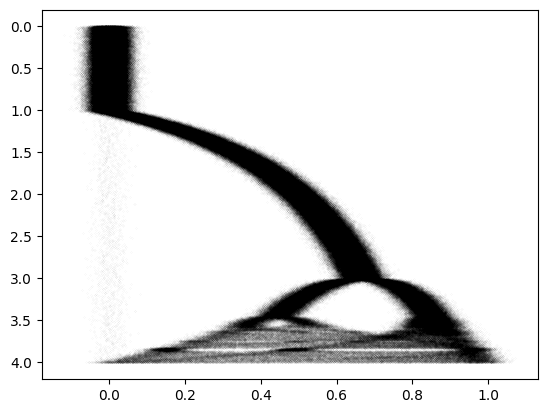

In [6]:
key = jax.random.PRNGKey(0)

# Add noise
sigma = 0.025
desired_shape = (data.shape[0], data.shape[1] * data.shape[2])
noise = jax.random.normal(key, shape=desired_shape)*sigma

pdata = data.reshape(desired_shape) + noise # Add noise for visualization, noise in trajectories are added below


fig, ax = plt.subplots()
ax.plot(pdata,
        rs,
        '.k',
        ms=0.1,
        alpha=0.3
)
ax.invert_yaxis()

logm_iterable

In [7]:
# Logistic map with noise
def logm_iterable(vars, n, sigma):
  r, x, key = vars
  key, subkey = jax.random.split(key)
  noise = jax.random.normal(subkey)*sigma
  return (r, r*x*(1 - x)+noise, key), (r, x)
logm_iterable = ft.partial(logm_iterable, sigma=0.0)

@ft.partial(jit, static_argnums=(3,))
@ft.partial(vmap, in_axes=(0, None, None, None), out_axes=0)
@ft.partial(vmap, in_axes=(None, 0, None, None), out_axes=0)
def logistic_map(r, x0, key, n):
  return scan(logm_iterable, (r, x0, key), jnp.arange(n))

In [8]:
x0s = jnp.linspace(0, 1, 100)
# rs = jnp.linspace(0, 4, 1_000)
rs = jnp.array([2.5, 2.75, 3.0, 3.25, 3.50, 3.75, 3.8, 3.85, 3.9, 3.95])
n = 500
key = jax.random.PRNGKey(0)
all_data = logistic_map(rs, x0s, key, n)
r_data, x_data = all_data[1]
_, final_xs, _ = all_data[0]

In [9]:
x_data_plot = x_data[:, :, -1:]

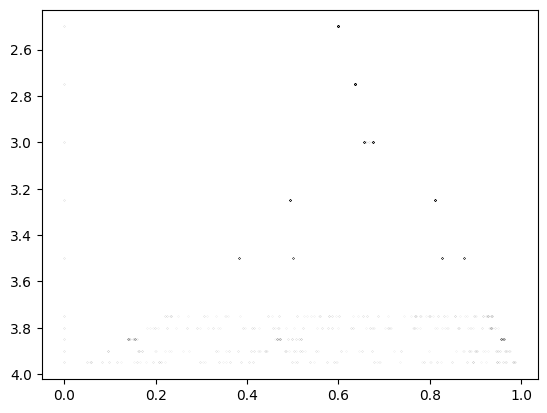

In [10]:
fig, ax = plt.subplots()
ax.plot(x_data_plot.reshape(x_data_plot.shape[0], x_data_plot.shape[1] * x_data_plot.shape[2]),
        rs,
        '.k',
        ms=0.1,
        alpha=0.5
)
ax.invert_yaxis()

Apply SINDY

X = [x.T, r.T]

dX = [(x+1).T, r.T]

In [11]:
n_rs = x_data.shape[0]
n_x0s = x_data.shape[1]
n_ts = x_data.shape[2]
n_traj = n_rs*n_x0s

In [12]:
x_traj_list = []
dx_traj_list = []
r_list = []
for r in range(n_rs):
    for x in range(n_x0s):
        traj = x_data[r, x, :]
        x_traj_list.append(traj[:-1])
        dx_traj_list.append(traj[1:])
        r_list.append(r_data[r, x, :-1])

X = jnp.stack((jnp.array(x_traj_list).flatten(), 
               jnp.array(r_list).flatten())).T

dX = jnp.stack((jnp.array(dx_traj_list).flatten(), 
                jnp.array(r_list).flatten())).T


In [13]:
def rand_func(r, x, key, sigma=0.025):
    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey)*sigma
    return r*x - r*x**2 + noise, key

In [14]:
key = jax.random.PRNGKey(0)
noise = jax.random.normal(key, shape=dX.shape)*jnp.array([sigma, 0]) # Add noise to derivatives, not r values
dX = dX + noise

dx_list = []
key = jax.random.PRNGKey(0)
for i, x in enumerate(X):
    # dx = func(x[1], x[0])
    dx, key = rand_func(x[1], x[0], key)
    dx_list.append(dx)

dX = dX.at[:, 0].set(jnp.array(dx_list)) # set the derivatives to be the noisy derivatives

In [69]:
from feature_maker import polynomial_features
from regression_algs import vanilla_SINDy
from regression_algs import l0_prox_op
import jax

Phi_fun, feature_list, feature_names = polynomial_features(2, 4)
Phi = Phi_fun(X)

# fit = vanilla_SINDy(Phi, dZ.T, 0.000005)

fit = vanilla_SINDy(Phi, dX, 0.025)
fit

Array([[ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  1.       ],
       [ 0.       ,  0.       ],
       [ 0.9998988,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [-0.9998808,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ]], dtype=float32)

In [62]:
import regression_algs as ra
import jax.numpy as jnp
# SR3 l0
Phi_fun, feature_list, feature_names = polynomial_features(2, 3)
Phi = Phi_fun(X)

C = jnp.eye(len(Phi[0]))
key, subkey = jax.random.split(jax.random.PRNGKey(0))
x_init = jax.random.normal(subkey, (Phi.shape[1], dX.shape[1]))
fit, _ = ra.SR3(Phi, dX, C, ra.l0_prox_op, x_init, prox_w=0.1)
fit

Array([[ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.9999999],
       [ 0.       ,  0.       ],
       [ 1.0063765,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [-1.000752 ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ]], dtype=float32)

In [55]:
import regression_algs as ra
import jax.numpy as jnp
# SR3 l1
Phi_fun, feature_list, feature_names = polynomial_features(2, 3)
Phi = Phi_fun(X)

C = jnp.eye(len(Phi[0]))
key, subkey = jax.random.split(jax.random.PRNGKey(0))
x_init = jax.random.normal(subkey, (Phi.shape[1], dX.shape[1]))
fit, _ = ra.SR3(Phi, dX, C, ra.l1_prox_op, x_init, prox_w=0.0001)
fit

Array([[-2.7646529e-02,  0.0000000e+00],
       [-1.5151394e-02, -0.0000000e+00],
       [ 2.9524112e-02,  9.9987030e-01],
       [ 7.8502130e-03, -0.0000000e+00],
       [ 1.0063006e+00,  0.0000000e+00],
       [-9.8999329e-03,  0.0000000e+00],
       [-1.6444875e-03, -0.0000000e+00],
       [-1.0011055e+00,  0.0000000e+00],
       [-6.5267080e-04, -0.0000000e+00],
       [ 9.8837691e-04, -0.0000000e+00]], dtype=float32)

In [70]:
def get_integrator(fit, feature_list):
    biginds = np.abs(fit) > 0

    lams = []
    for j in range(fit.shape[1]):
        inds = biginds.astype(int)[:, j]
        lam = []
        for i in range(fit.shape[0]):
            if inds[i]!=0:
                lam.append([fit[i, j], feature_list[i]])
        lamm = lambda x, lam=lam: sum([f[0]*f[1](x) for f in lam])
        lams.append(lamm)

    def integrator(t, x):
        dX = tuple(lams[i](x) for i in range(len(lams)))
        return dX
    
    return integrator

integrator = ft.partial(get_integrator(fit[:, ::-1], feature_list), (0, None))

In [71]:
# Your code here - Demonstrate that it works
def logm_iterable(vars, n):
  r = vars[0]
  x = vars[1]
  # return (r, r*x*(1 - x)), x
  # return func(r, x), x
  # return new_func(x, r), x
  return integrator((x, r)), x
  # return (r, r*x*(1 - x)), x

# @ft.partial(jit, static_argnums=(2,))
@ft.partial(vmap, in_axes=(0, None, None), out_axes=0)
@ft.partial(vmap, in_axes=(None, 0, None), out_axes=0)
def logistic_map(r, x0, n):
  return scan(logm_iterable, (r, x0), jnp.arange(n))[1]

# logistic_map(jnp.array([1]), jnp.array([2]), 3)

In [72]:
x0s = jnp.linspace(0, 1, 100)
rs = jnp.linspace(0, 4, 1_000)
n = 1000
data = logistic_map(rs, x0s, n)

In [73]:
data.shape

(1000, 100, 1000)

In [74]:
data = data[:, :, -1:]

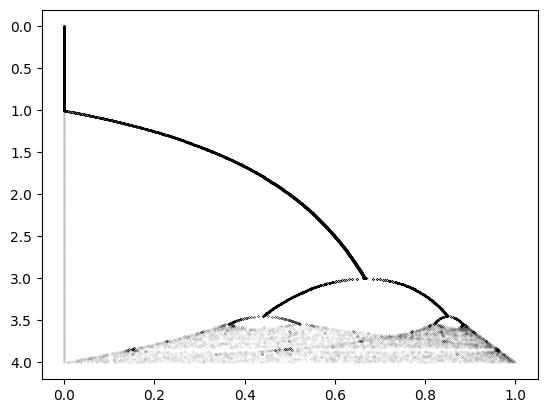

In [75]:
fig, ax = plt.subplots()
ax.plot(data.reshape(data.shape[0], data.shape[1] * data.shape[2]),
        rs,
        '.k',
        ms=0.1,
        alpha=0.5
)
ax.invert_yaxis()